In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from core.extractor import (
    ColorExtractor,
    ConceptFusionFeatureExtractor,
    GroundedSAMInstanceExtractor,
    LSegFeatureExtractor,
    MaskRCNNMaskExtractor,
    RandomSAMFeatureExtractor,
    SAMMaskExtractor,
)
from core.extractor.utils import get_kmeans_labels, show_mask
from core.labeler import BaseLabeler, CLIPTextQuerier, KMeansLabeler

In [3]:
sam_ckpt = "/home/quanta/Models/SAM/sam_vit_h_4b8939.pth"
sam_type = "vit_h"
clip_type = "ViT-B/32"  # this is the clip model used by clip-glass and DeCap
clip_download_root = "/home/quanta/.cache/clip"
lseg_ckpt = "/home/quanta/Models/LSeg/lseg_minimal_e200.ckpt"
grounding_dino_config_pth = "../examples/grounding_dino_config/GroundingDINO_SwinT_OGC.py"
grounding_dino_ckpt = "/home/quanta/Models/GroundingDINO/groundingdino_swint_ogc.pth"
ram_ckpt = "/home/quanta/Models/RAM_Tag2Text/ram_swin_large_14m.pth"
sam_hq_ckpt = "/home/quanta/Models/SAM_HQ/sam_hq_vit_h.pth"
mask_rcnn_ckpt = '/home/quanta/Models/scannet_mask_rcnn/model_0454999.pth'

In [4]:
img_path = '/home/quanta/Datasets/ScanNet/scans/scene0000_00/data/color/0.jpg'
img = Image.open(img_path)
device = 'cuda:0'

In [5]:
extractor = LSegFeatureExtractor(lseg_ckpt=lseg_ckpt, device=device)
torch.cuda.empty_cache()
extractor.load_model()

In [6]:
results = extractor.extract(img)
feats = extractor.get_feats(results)

In [7]:
klabeler = KMeansLabeler(K=20, device=device)

In [8]:
labels = klabeler.feat_to_label(feats)

In [9]:
colors = klabeler.label_to_color(labels)

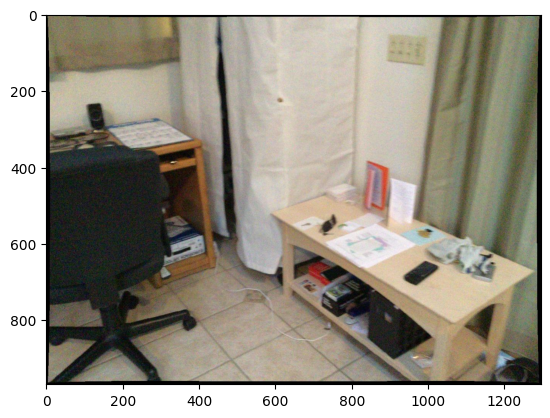

In [19]:
plt.imshow(img)

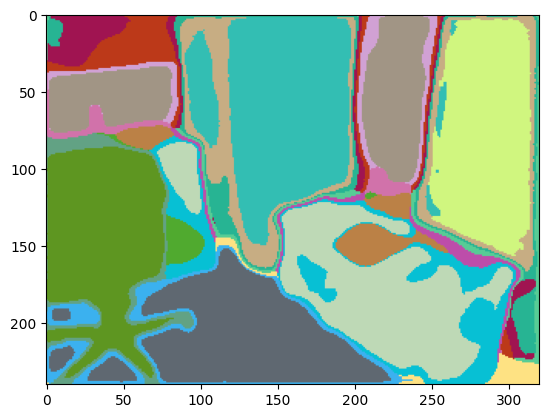

In [10]:
plt.imshow(colors)

In [11]:
clip_query = CLIPTextQuerier(device=device)

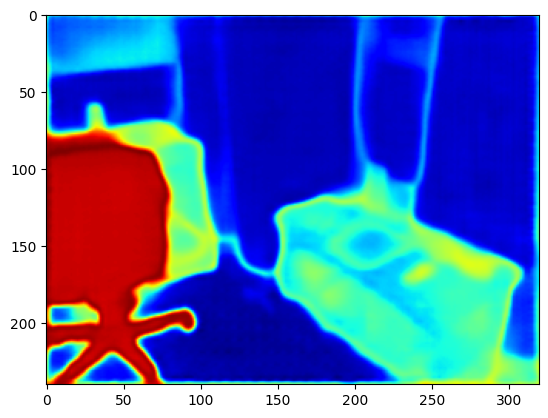

In [12]:
score = clip_query.single_text_score('computer chair', feats)

colors = clip_query.score_to_color(score, scheme='jet', normalize=True)

plt.imshow(colors)

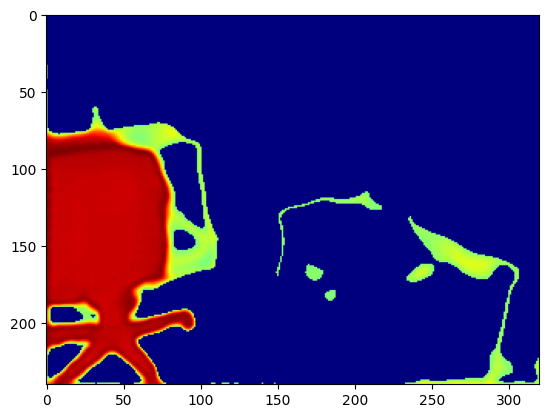

In [13]:
colors = clip_query.score_to_color(score, scheme='jet', normalize=True, threshold=0.5)
plt.imshow(colors)

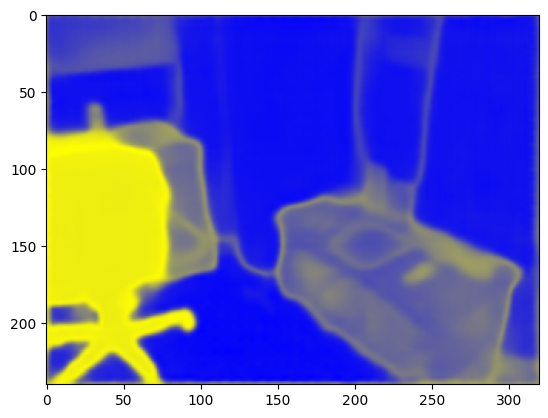

In [14]:
colors = clip_query.score_to_color(score, scheme='by', normalize=True)
plt.imshow(colors)

In [16]:
score = clip_query.single_text_others_score('cabinet', feats)

In [17]:
score.shape

torch.Size([240, 320])

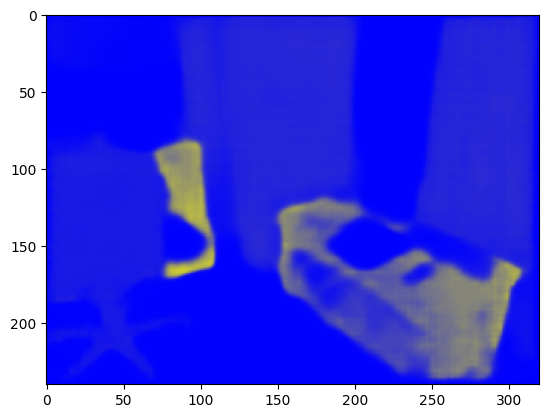

In [18]:
colors = clip_query.score_to_color(score, scheme='by', normalize=False)
plt.imshow(colors)

In [20]:
from core.dataset.scannet import NYU_ID_TO_COLOR, class_info

In [22]:
nyu_id_to_class = class_info('/home/quanta/Datasets/ScanNet/')[0]

In [29]:
class_ = [ nyu_id_to_class[i] for i in range(41)]

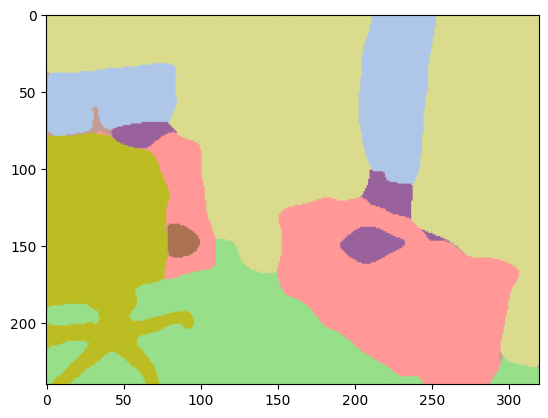

In [36]:
labels = clip_query.multi_text_query(class_, feats)

colors = clip_query.label_to_color(
    labels,
    scheme="ext",
    ext_scheme=NYU_ID_TO_COLOR,
)

plt.imshow(colors)